# Random Dot Product Graphs (RDPG)

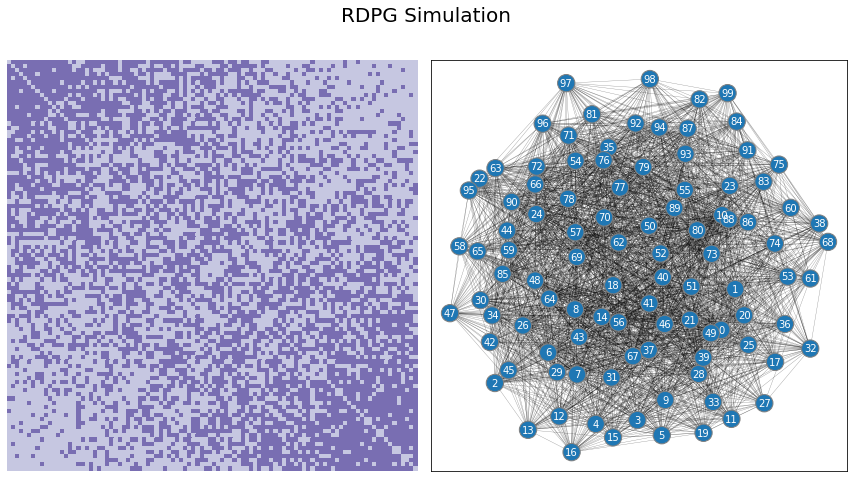

In [2]:
import numpy as np
from graspologic.simulations import rdpg
from graphbook_code import draw_multiplot

n = 100  # the number of nodes in our network

# design the latent position matrix X according to 
# the rules we laid out previously
X = np.zeros((n,2))
for i in range(0, n):
    X[i,:] = [(n - i)/n, i/n]

from graspologic.simulations import rdpg
from graphbook_code import draw_multiplot

A = rdpg(X, directed=False, loops=False)
draw_multiplot(A, title="RDPG Simulation");

## Latent Positions

Let's imagine that we have a network which follows the *a priori* Stochastic Block Model. To make this example a little bit more concrete, let's borrow the code example from above. The nodes of our network represent each of the $100$ students in our network. The node assignment vector represents which of the two schools eaach student attends, where the first $50$ students attend the first school, and the second $50$ students attend school $2$. Remember that $\tau$ and $B$ look like:

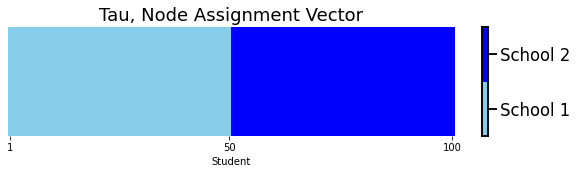

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

def plot_tau(tau, title="", xlab="Node"):
    cmap = matplotlib.colors.ListedColormap(["skyblue", 'blue'])
    fig, ax = plt.subplots(figsize=(10,2))
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap((tau - 1).reshape((1,tau.shape[0])), cmap=cmap,
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.25, .75])
        cbar.set_ticklabels(['School 1', 'School 2'])
        ax.set(xlabel=xlab)
        ax.set_xticks([.5,49.5,99.5])
        ax.set_xticklabels(["1", "50", "100"])
        cbar.ax.set_frame_on(True)
    return

n = 100  # number of students

# tau is a column vector of 150 1s followed by 50 2s
# this vector gives the school each of the 300 students are from
tau = np.vstack((np.ones((int(n/2),1)), np.full((int(n/2),1), 2)))

plot_tau(tau, title="Tau, Node Assignment Vector",
        xlab="Student")

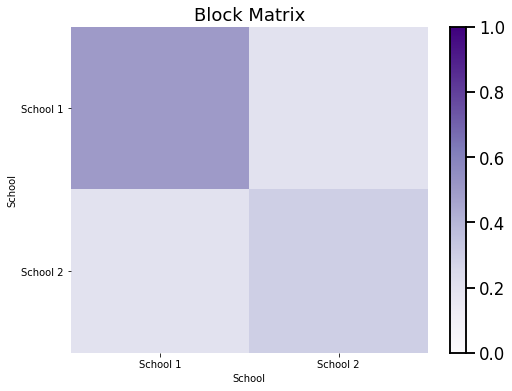

In [4]:
K = 2  # 2 communities in total
# construct the block matrix B as described above
B = [[0.5, 0.2], [0.2, 0.3]]

def plot_block(X, title="", blockname="School", blocktix=[0.5, 1.5],
               blocklabs=["School 1", "School 2"]):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=blockname, xlabel=blockname)
        ax.set_yticks(blocktix)
        ax.set_yticklabels(blocklabs)
        ax.set_xticks(blocktix)
        ax.set_xticklabels(blocklabs)
        cbar.ax.set_frame_on(True)
    return

plot_block(B, title="Block Matrix")
plt.show()

Are there any other ways to describe this scenario, other than using both $\tau$ and $B$?

What if we were to look at the probabilities for *every* pair of edges? Remember, for a given $\tau$ and $B$, that a network which is SBM can be generated using the approach that, given that $\tau_i = \ell$ and $\tau_j = k$, that $\mathbf a_{ij} \sim Bern(b_{\ell k})$. That is, every entry is Bernoulli, with the probability indicated by appropriate entry of the block matrix corresponding to the pair of communities each node is in. However, there's another way we could write down this generative model. Suppose we had a $n \times n$ probability matrix, where for every $j > i$:
\begin{align*}
    p_{ji} = p_{ij}, p_{ij} = \begin{cases}
        b_{11} & \tau_i = 1, \tau_j = 1 \\
        b_{12} & \tau_i = 1, \tau_j = 2 \\
        b_{22} & \tau_i = 2, \tau_j = 1
    \end{cases}
\end{align*}
This matrix $P$ with entries $p_{ij}$ is the probability matrix associated with the *a priori* SBM, which we described in the section [](representations:whyuse:networkmodels:iern). 
If you've been following the advanced sections, you will already be familiar with this term. Simply put, this matrix describes the probability of each edge $(i,j)$ existing. What does $P$ look like?

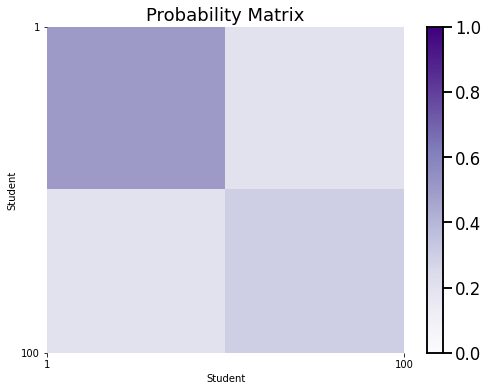

In [5]:
def plot_prob(X, title="", nodename="Student", nodetix=None,
             nodelabs=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=0, vmax=1)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=nodename)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
            ax.set_xticks(nodetix)
            ax.set_xticklabels(nodelabs)
        cbar.ax.set_frame_on(True)
    return

P = np.zeros((n,n))
P[0:50,0:50] = .5
P[50:100, 50:100] = .3
P[0:50,50:100] = .2
P[50:100,0:50] = .2

ax = plot_prob(P, title="Probability Matrix", nodetix=[0,100],
              nodelabs=["1", "100"])
plt.show()

As we can see, $P$ captures a similar modular structure to the actual adjacency matrix corresponding to the SBM network. When we say this network is *modular*, we mean that it looks block-y, in that there are clusters of edges sharing a similar probability. Also, $P$ captures the probability of connections between each pair of students. Indeed, it is the case that $P$ contains the information of both $\vec\tau$ and $B$. This means that we can write down a generative model by specifying *only* $P$, and we no longer need to specify $\vec\tau$ and $B$ at all. To write down the generative model in this way, we say that for all $j > i$, that $\mathbf a_{ij} \sim Bern(p_{ij})$ independently, where $\mathbf a_{ji} = \mathbf a_{ij}$, and $\mathbf a_{ii} = 0$.

What is so special about this formulation of the SBM problem? As it turns out, for a *positive semi-definite* probability matrix $P$, $P$ can be decomposed using a matrix $X$, where $P = X X^\top$. We will call a single row of $X$ the vector $\vec x_i$. Remember, using this expression, each entry $p_{ij}$ is the product $\vec x_i^\top \vec x_j$, for all $i, j$. Like $P$, $X$ has $n$ rows, each of which corresponds to a single node in our network. However, the special property of $X$ is that it doesn't *necessarily* have $n$ columns: rather, $X$ often will have many fewer columns than rows. For instance, with $P$ as above, there in fact exists an $X$ with just $2$ columns that can be used to describe $P$. This matrix $X$ will be called the **latent position matrix**, and each row $\vec x_i$ will be called the **latent position of a node**.

Now, your next thought might be that this requires a *lot* more space to represent an SBM network, and you'd be right: $\vec \tau$ has $n$ entries, and $B$ has $K \times K$ entries, where $K$ is typically much smaller than $n$. On the other hand, in this formulation, $P$ has $\binom{n}{2}$ entries, which is much bigger than $n + K \times K$ (since $K$ is usually much smaller than $n$). The advantage is that under this formulation, $P$ doesn't need to have this rigorous modular structure characteristic of SBM networks, and can look a *lot* more interesting. As we will see in later chapters, this network representation will prove extremely flexible for allowing us to capture networks that are fairly complex. Further, we can also perform analysis on the matrix $X$ itself, which will prove very useful for estimation of SBMs.

## *A Priori* RDPG

The *a priori* Random Dot Product Graph is an RDPG in which we know *a priori* the latent position matrix $X$. The *a priori* RDPG has the following parameter:

| Parameter | Space | Description |
| --- | --- | --- |
| $X$ | $ \mathbb R^{n \times d}$ | The matrix of latent positions for each node $n$. |

$X$ is called the **latent position matrix** of the RDPG. We write that $X \in \mathbb R^{n \times d}$, which means that it is a matrix with real values, $n$ rows, and $d$ columns. We will use the notation $\vec x_i$ to refer to the $i^{th}$ row of $X$. $\vec x_i$ is referred to as the **latent position** of a node $i$. This looks something like this:
\begin{align*}
    X = \begin{bmatrix}
     \vec x_{1}^\top \\
     \vdots \\
     \vec x_n^\top
    \end{bmatrix}
\end{align*}
Noting that $X$ has $d$ columns, this implies that $\vec x_i \in  \mathbb R^d$, or that each node's latent position is a real-valued $d$-dimensional vector.

What is the generative model for the *a priori* RDPG? As we discussed above, given $X$, for all $j > i$, $\mathbf a_{ij} \sim Bern(\vec x_i^\top \vec x_j)$ independently. If $i < j$, $\mathbf a_{ji} = \mathbf a_{ij}$ (the network is *undirected*), and $\mathbf a_{ii} = 0$ (the network is *loopless*). If $\mathbf A$ is an *a priori* RDPG with parameter $X$, we write that $\mathbf A \sim RDPG_n(X)$. 

### Code Examples

We will let $X$ be a little more complex than in our preceding example. Our $X$ will produce a $P$ that still *somewhat* has a modular structure, but not quite as much as before. Let's assume that we have $100$ people who live along a very long road that is $100$ miles long, and each person is $1$ mile apart. The nodes of our network represent the people who live along our assumed street. If two people are closer to one another, it might make sense to think that they have a higher probability of being friends. If two people are neighbors, we think that they will have a very high probability of being friends (almost $1$) and when people are very far apart, we think that they will have a very low probability of being friends (almost $0$). What could we use for $X$?

Remember that the latent positions for each node $i$ are denoted by the vector $\vec x_i$. One possible approach would be to let each $\vec x_i$ be defined as follows:
\begin{align*}
    \vec x_i = \begin{bmatrix}
        \frac{100 - i}{100} \\
        \frac{i}{100}
    \end{bmatrix}
\end{align*}
For instance, $\vec x_1 = \begin{bmatrix}1 \\ 0\end{bmatrix}$, and $\vec x_{100} = \begin{bmatrix} 0 \\ 1\end{bmatrix}$. Note that:
\begin{align*}
p_{1,100} = \vec x_1^\top \vec x_j = 1 \cdot 0 + 0 \cdot 1 = 0
\end{align*}
What happens in between?

Let's consider another person, person $30$. Note that person $30$ lives closer to person $1$ than to person $100$.  Here, $\vec x_{30} = \begin{bmatrix} \frac{7}{10}\\ \frac{3}{10}\end{bmatrix}$. This gives us that:
\begin{align*}
p_{1,30} &= \vec x_1^\top \vec x_{30} = \frac{7}{10}\cdot 1 + 0 \cdot \frac{3}{10} = \frac{7}{10} \\
p_{30, 100} &= \vec x_{30}^\top x_{100} = \frac{7}{10} \cdot 0 + \frac{3}{10} \cdot 1 = \frac{3}{10}
\end{align*}
So this means that person $1$ and person $30$ have a $70\%$ probability of being friends, but person $30$ and $100$ have onl6 a $30\%$ probability of being friends.

Intuitively, it seems like our probability matrix $P$ will capture the intuitive idea we described above. First, we'll take a look at $X$, and then we'll look at $P$:

In [6]:
n = 100  # the number of nodes in our network

# design the latent position matrix X according to 
# the rules we laid out previously
X = np.zeros((n,2))
for i in range(0, n):
    X[i,:] = [(n - i)/n, i/n]

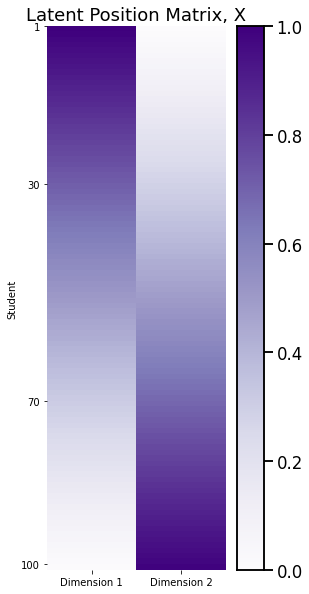

In [7]:
def plot_lp(X, title="", ylab="Student"):
    fig, ax = plt.subplots(figsize=(4, 10))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=ylab)
        ax.set_yticks([0, 29, 69, 99])
        ax.set_yticklabels(["1", "30", "70", "100"])
        ax.set_xticks([.5, 1.5])
        ax.set_xticklabels(["Dimension 1", "Dimension 2"])
        cbar.ax.set_frame_on(True)
    return

plot_lp(X, title="Latent Position Matrix, X")

The latent position matrix $X$ that we plotted above is $n \times d$ dimensions. There are a number of approaches, other than looking at a heatmap of $X$, with which we can visualize $X$ to derive insights as to its structure. When $d=2$, another popular visualization is to look at the latent positions, $\vec x_i$, as individual points in $2$-dimensional space. This will give us a scatter plot of $n$ points, each of which has two coordinates. Each point is the latent position for a single node:

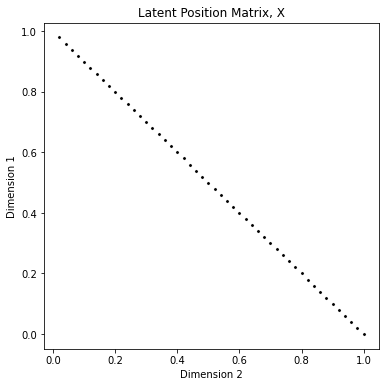

In [8]:
def plot_latents(latent_positions, title=None, labels=None, **kwargs):
    fig, ax = plt.subplots(figsize=(6, 6))
    if ax is None:
        ax = plt.gca()
    ss = 2*np.arange(0, 50)
    plot = sns.scatterplot(x=latent_positions[ss, 0], y=latent_positions[ss, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1", color='k', **kwargs)
    ax.set_title(title)
    ax.set(ylabel="Dimension 1", xlabel="Dimension 2")
    ax.set_title(title)
    return plot

# plot
plot_latents(X, title="Latent Position Matrix, X");

The above scatter plot has been subsampled to show only every $2^{nd}$ latent position, so that the individual $2$-dimensional latent positions are discernable. Due to the way we constructed $X$, the scatter plot would otherwise appear to be a line (due to points overlapping one another). The reason that the points fall along a vertical line when plotted as a vector is due to the method we used to construct entries of $X$, described above. Next, we will look at the probability matrix:

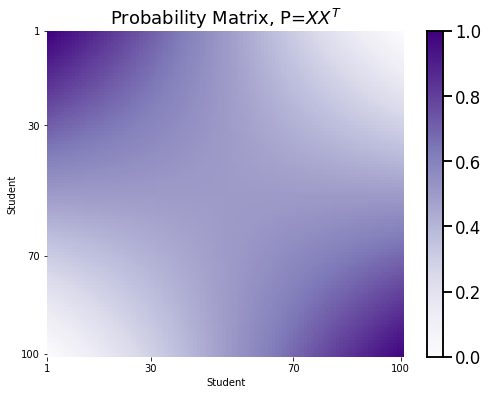

In [9]:
plot_prob(X.dot(X.transpose()), title="Probability Matrix, P=$XX^T$",
         nodelabs=["1", "30", "70", "100"], nodetix=[0,29,69,99])

Finally, we will sample an RDPG:

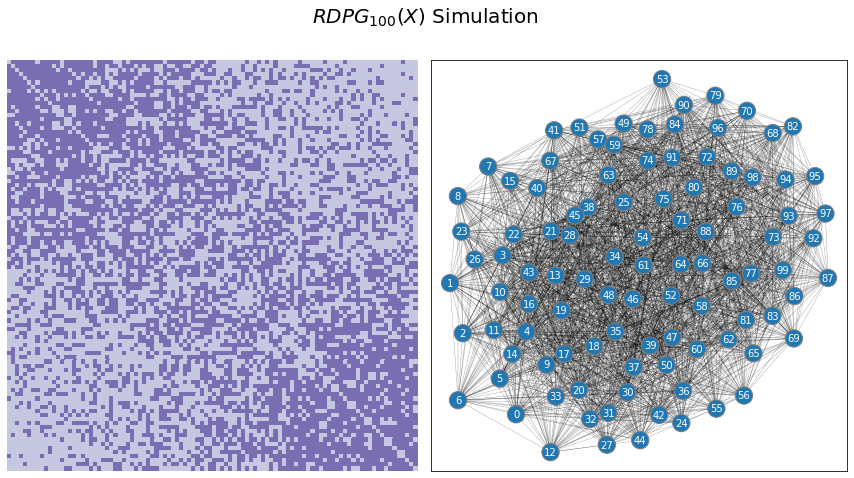

In [10]:
from graspologic.simulations import rdpg
from graphbook_code import draw_multiplot

# sample an RDPG with the latent position matrix
# created above
A = rdpg(X, loops=False, directed=False)

# and plot it
ax = draw_multiplot(A, title="$RDPG_{100}(X)$ Simulation")

### Probability*

Given $X$, the probability for an RDPG is relatively straightforward, as an RDPG is another Independent-Edge Random Graph. The independence assumption vastly simplifies our resulting expression. We will also use many of the results we've identified above, such as the p.m.f. of a Bernoulli random variable. Finally, we'll note that the probability matrix $P = (\vec x_i^\top \vec x_j)$, so $p_{ij} = \vec x_i^\top \vec x_j$:

\begin{align*}
    \mathbb P_\theta(A) &= \mathbb P_\theta(A) \\
    &= \prod_{j > i}\mathbb P(\mathbf a_{ij} = a_{ij}),\;\;\;\; \textrm{Independence Assumption} \\
    &= \prod_{j > i}(\vec x_i^\top \vec x_j)^{a_{ij}}(1 - \vec x_i^\top \vec x_j)^{1 - a_{ij}},\;\;\;\; a_{ij} \sim Bern(\vec x_i^\top \vec x_j)
\end{align*}

Unfortunately, the probability equivalence classes are a bit harder to understand intuitionally here compared to the ER and SBM examples so we won't write them down here, but they still exist!

## *A Posteriori* RDPG

Like for the *a posteriori* SBM, the *a posteriori* RDPG introduces another strange set: the **intersection of the unit ball and the non-negative orthant**. Huh? This sounds like a real mouthful, but it turns out to be rather straightforward. You are probably already very familiar with a particular orthant: in two-dimensions, an orthant is called a quadrant. Basically, an orthant just extends the concept of a quadrant to spaces which might have more than $2$ dimensions. The non-negative orthant happens to be the orthant where all of the entries are non-negative. We call the **$K$-dimensional non-negative orthant** the set of points in $K$-dimensional real space, where:
\begin{align*}
    \left\{\vec x \in \mathbb R^K : x_k \geq 0\text{ for all $k$}\right\}
\end{align*}
In two dimensions, this is the traditional upper-right portion of the standard coordinate axis. To give you a picture, the $2$-dimensional non-negative orthant is the blue region of the following figure:

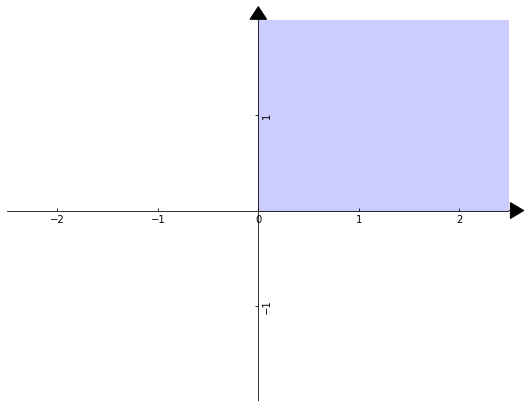

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist import SubplotZero
import matplotlib.patches as patch

class myAxes():
    
    def __init__(self, xlim=(-5,5), ylim=(-5,5), figsize=(6,6)):
        self.xlim = xlim
        self.ylim = ylim
        self.figsize  = figsize
        self.__scale_arrows()
    def __drawArrow(self, x, y, dx, dy, width, length):
        plt.arrow(
            x, y, dx, dy, 
            color       = 'k',
            clip_on     = False, 
            head_width  = self.head_width, 
            head_length = self.head_length
        ) 
        
    def __scale_arrows(self):
        """ Make the arrows look good regardless of the axis limits """
        xrange = self.xlim[1] - self.xlim[0]
        yrange = self.ylim[1] - self.ylim[0]
        
        self.head_width  = min(xrange/30, 0.25)
        self.head_length = min(yrange/30, 0.3)
        
    def __drawAxis(self):
        """
        Draws the 2D cartesian axis
        """
        # A subplot with two additional axis, "xzero" and "yzero"
        # corresponding to the cartesian axis
        ax = SubplotZero(self.fig, 1, 1, 1)
        self.fig.add_subplot(ax)
        
        # make xzero axis (horizontal axis line through y=0) visible.
        for axis in ["xzero","yzero"]:
            ax.axis[axis].set_visible(True)
        # make the other axis (left, bottom, top, right) invisible
        for n in ["left", "right", "bottom", "top"]:
            ax.axis[n].set_visible(False)
            
        # Plot limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        ax.set_yticks([-1, 1, ])
        ax.set_xticks([-2, -1, 0, 1, 2])
        # Draw the arrows
        self.__drawArrow(self.xlim[1], 0, 0.01, 0, 0.3, 0.2) # x-axis arrow
        self.__drawArrow(0, self.ylim[1], 0, 0.01, 0.2, 0.3) # y-axis arrow
        self.ax=ax
        
    def draw(self):
        # First draw the axis
        self.fig = plt.figure(figsize=self.figsize)
        self.__drawAxis()

axes = myAxes(xlim=(-2.5,2.5), ylim=(-2,2), figsize=(9,7))
axes.draw()

rectangle =patch.Rectangle((0,0), 3, 3, fc='blue',ec="blue", alpha=.2)
axes.ax.add_patch(rectangle)
plt.show()

Now, what is the unit ball? You are probably familiar with the idea of the unit ball, even if you haven't heard it called that specifically. Remember that the Euclidean norm for a point $\vec x$ which has coordinates $x_i$ for $i=1,...,K$ is given by the expression:
\begin{align*}
    \left|\left|\vec x\right|\right|_2 = \sqrt{\sum_{i = 1}^K x_i^2}
\end{align*}
The Euclidean unit ball is just the set of points whose Euclidean norm is at most $1$. To be more specific, the **closed unit ball** with the Euclidean norm is the set of points:
\begin{align*}
    \left\{\vec x \in \mathbb R^K :\left|\left|\vec x\right|\right|_2 \leq 1\right\}
\end{align*}

We draw the $2$-dimensional unit ball with the Euclidean norm below, where the points that make up the unit ball are shown in red:

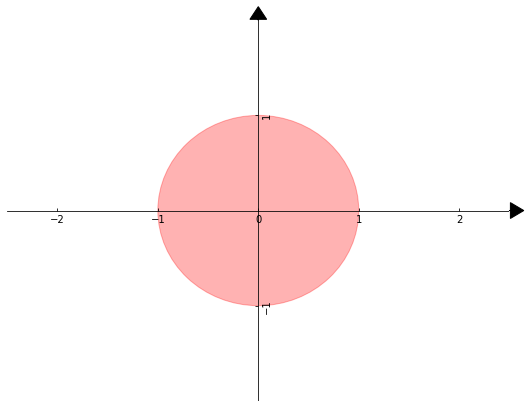

In [12]:
axes = myAxes(xlim=(-2.5,2.5), ylim=(-2,2), figsize=(9,7))
axes.draw()

circle =patch.Circle((0,0), 1, fc='red',ec="red", alpha=.3)
axes.ax.add_patch(circle)
plt.show()

Now what is their intersection? Remember that the intersection of two sets $A$ and $B$ is the set:
\begin{align*}
    A \cap B &= \{x : x \in A, x \in B\}
\end{align*}
That is, each element must be in *both* sets to be in the intersection. The interesction of the unit ball and the non-negative orthant will be the set:

\begin{align*}
   \mathcal X_K = \left\{\vec x \in \mathbb R^K :\left|\left|\vec x\right|\right|_2 \leq 1, x_k \geq 0 \textrm{ for all $k$}\right\}
\end{align*}

visually, this will be the set of points in the *overlap* of the unit ball and the non-negative orthant, which we show below in purple: 

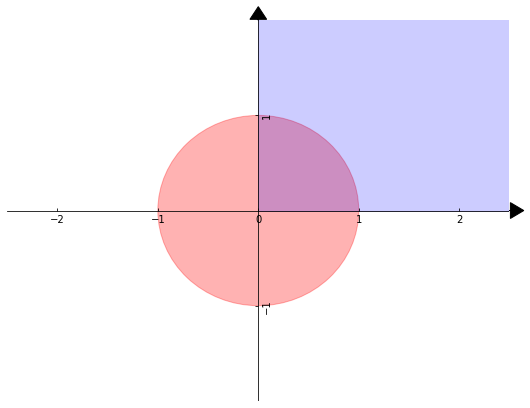

In [13]:
axes = myAxes(xlim=(-2.5,2.5), ylim=(-2,2), figsize=(9,7))
axes.draw()

circle =patch.Circle((0,0), 1, fc='red',ec="red", alpha=.3)
axes.ax.add_patch(circle)
rectangle =patch.Rectangle((0,0), 3, 3, fc='blue',ec="blue", alpha=.2)
axes.ax.add_patch(rectangle)
plt.show()

This space has an *incredibly* important corollary. It turns out that if $\vec x$ and $\vec y$ are both elements of $\mathcal X_K$, that $\left\langle \vec x, \vec y \right \rangle = \vec x^\top \vec y$, the **inner product**, is at most $1$, and at least $0$. Without getting too technical, this is because of something called the Cauchy-Schwartz inequality and the properties of $\mathcal X_K$. If you remember from linear algebra, the Cauchy-Schwartz inequality states that $\left\langle \vec x, \vec y \right \rangle$ can be at most the product of $\left|\left|\vec x\right|\right|_2$ and $\left|\left|\vec y\right|\right|_2$. Since $\vec x$ and $\vec y$ have norms both less than or equal to $1$ (since they are on the *unit ball*), their inner-product is at most $1$. Further, since $\vec x$ and $\vec y$ are in the non-negative orthant, their inner product can never be negative. This is because both $\vec x$ and $\vec y$ have entries which are not negative, and therefore their element-wise products can never be negative.


The *a posteriori* RDPG is to the *a priori* RDPG what the *a posteriori* SBM was to the *a priori* SBM. We instead suppose that we do *not* know the latent position matrix $X$, but instead know how we can characterize the individual latent positions. We have the following parameter:

| Parameter | Space | Description |
| --- | --- | --- |
| F | inner-product distributions | A distribution which governs each latent position. |

The parameter $F$ is what is known as an **inner-product distribution**. In the simplest case, we will assume that $F$ is a distribution on a subset of the possible real vectors that have $d$-dimensions with an important caveat: for any two vectors within this subset, their inner product *must* be a probability. We will refer to the subset of the possible real vectors as $\mathcal X_K$, which we learned about above. This means that for any $\vec x_i, \vec x_j$ that are in $\mathcal X_K$, it is always the case that $\vec x_i^\top \vec x_j$ is between $0$ and $1$. This is essential because like previously, we will describe the distribution of each edge in the adjacency matrix using $\vec x_i^\top \vec x_j$ to represent a probability. Next, we will treat the latent position matrix as a matrix-valued random variable which is *latent* (remember, *latent* means that we don't get to see it in our real data). Like before, we will call $\vec{\mathbf x}_i$ the random latent positions for the nodes of our network. In this case, each $\vec {\mathbf x}_i$ is sampled independently and identically from the inner-product distribution $F$ described above. The latent-position matrix is the matrix-valued random variable $\mathbf X$ whose entries are the latent vectors $\vec {\mathbf x}_i$, for each of the $n$ nodes. 

The model for edges of the *a posteriori* RDPG can be described by conditioning on this unobserved latent-position matrix. We write down that, conditioned on $\vec {\mathbf x}_i = \vec x$ and $\vec {\mathbf x}_j = \vec y$, that if $j > i$, then $\mathbf a_{ij}$ is sampled independently from a $Bern(\vec x^\top \vec y)$ distribution. As before, if $i < j$, $\mathbf a_{ji} = \mathbf a_{ij}$ (the network is *undirected*), and $\mathbf a_{ii} = 0$ (the network is *loopless*). If $\mathbf A$ is the adjacency matrix for an *a posteriori* RDPG with parameter $F$, we write that $\mathbf A \sim RDPG_n(F)$. 

### Probability*

The probability for the *a posteriori* RDPG is fairly complicated. This is because, like the *a posteriori* SBM, we do not actually get to see the latent position matrix $\mathbf X$, so we need to use *integration* to obtain an expression for the probability. Here, we are concerned with realizations of $\mathbf X$. Remember that $\mathbf X$ is just a matrix whose rows are $\vec {\mathbf x}_i$, each of which individually have have the distribution $F$; e.g., $\vec{\mathbf x}_i \sim F$ independently. For simplicity, we will assume that $F$ is a disrete distribution on $\mathcal X_K$. This makes the logic of what is going on below much simpler since the notation gets less complicated, but does not detract from the generalizability of the result (the only difference is that sums would be replaced by multivariate integrals, and probability mass functions replaced by probability density functions). 

We will let $p$ denote the probability mass function (p.m.f.) of this discrete distribution function $F$. The strategy will be to use the independence assumption, followed by integration over the relevant rows of $\mathbf X$:

\begin{align*}
\mathbb P_\theta(A) &= \mathbb P_\theta(\mathbf A = A) \\
&= \prod_{j > i} \mathbb P(\mathbf a_{ij} = a_{ij}), \;\;\;\;\textrm{Independence Assumption} \\
\mathbb P(\mathbf a_{ij} = a_{ij})&= \sum_{\vec x \in \mathcal X_K}\sum_{\vec y \in \mathcal X_K}\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y),\;\;\;\;\textrm{integration over }\vec {\mathbf x}_i \textrm{ and }\vec {\mathbf x}_j
\end{align*}
Next, we will simplify this expression a little bit more, using the definition of a conditional probability like we did before for the SBM:

\begin{align*}
\\
\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &= \mathbb P(\mathbf a_{ij} = a_{ij}| \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) \mathbb P(\vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y)
\end{align*}

Further, remember that if $\mathbf a$ and $\mathbf b$ are independent, then $\mathbb P(\mathbf a = a, \mathbf b = b) = \mathbb P(\mathbf a = a)\mathbb P(\mathbf b = b)$. Using that $\vec x_i$ and $\vec x_j$ are independent, by definition:

\begin{align*}
\mathbb P(\vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &= \mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}

Which means that:

\begin{align*}
\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &=  \mathbb P(\mathbf a_{ij} = a_{ij} | \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y)\mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}
Finally, we that conditional on $\vec{\mathbf x}_i = \vec x_i$ and $\vec{\mathbf x}_j = \vec x_j$, $\mathbf a_{ij}$ is $Bern(\vec x_i^\top \vec x_j)$. This means that in terms of our probability matrix, each entry $p_{ij} = \vec x_i^\top \vec x_j$. Therefore:

\begin{align*}
\mathbb P(\mathbf a_{ij} = a_{ij}| \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &= (\vec x^\top \vec y)^{a_{ij}}(1 - \vec x^\top\vec y)^{1 - a_{ij}}
\end{align*}
This implies that:
\begin{align*}
\mathbb P(\mathbf a_{ij} = a_{ij}, \vec{\mathbf x}_i = \vec x, \vec{\mathbf x}_j = \vec y) &=  (\vec x^\top \vec y)^{a_{ij}}(1 - \vec x^\top\vec y)^{1 - a_{ij}}\mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}


So our complete expression for the probability is:

\begin{align*}
\mathbb P_\theta(A) &= \prod_{j > i}\sum_{\vec x \in \mathcal X_K}\sum_{\vec y \in \mathcal X_K} (\vec x^\top \vec y)^{a_{ij}}(1 - \vec x^\top\vec y)^{1 - a_{ij}}\mathbb P(\vec{\mathbf x}_i = \vec x) \mathbb P(\vec{\mathbf x}_j = \vec y)
\end{align*}

# Generalized Random Dot Product Graph (GRDPG)

The Generalized Random Dot Product Graph, or GRDPG, is the most general random network model we will consider in this book. Note that for the RDPG, the probability matrix $P$ had entries $p_{ij} = \vec x_i^\top \vec x_j$. What about $p_{ji}$? Well, $p_{ji} = \vec x_j^\top \vec x_i$, which is exactly the same as $p_{ij}$! This means that even if we were to consider a directed RDPG, the probabilities that can be captured are *always* going to be symmetric. The generalized random dot product graph, or GRDPG, relaxes this assumption. This is achieved by using *two* latent positin matrices, $X$ and $Y$, and letting $P = X Y^\top$. Now, the entries $p_{ij} = \vec x_i^\top \vec y_j$, but $p_{ji} = \vec x_j^\top \vec y_i$, which might be different.

## *A Priori* GRDPG

The *a priori* GRDPG is a GRDPG in which we know *a priori* the latent position matrices $X$ and $Y$. The *a priori* GRDPG has the following parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $X$ | $ \mathbb R^{n \times d}$ | The matrix of left latent positions for each node $n$. |
| $Y$ | $ \mathbb R^{n \times d}$ | The matrix of right latent positions for each node $n$. |

$X$ and $Y$ behave nearly the same as the latent position matrix $X$ for the *a priori* RDPG, with the exception that they will be called the **left latent position matrix** and the **right latent position matrix** respectively. Further, the vectors $\vec x_i$ will be the left latent positions, and $\vec y_i$ will be the right latent positions, for a given node $i$, for each node $i=1,...,n$.

What is the generative model for the *a priori* GRDPG? As we discussed above, given $X$ and $Y$, for all $j \neq i$, $\mathbf a_{ij} \sim Bern(\vec x_i^\top \vec y_j)$ independently. If we consider only loopless networks, $\mathbf a_{ij} = 0$. If $\mathbf A$ is an *a priori* GRDPG with left and right latent position matrices $X$ and $Y$, we write that $\mathbf A \sim GRDPG_n(X, Y)$.

## *A Posteriori* GRDPG

The *A Posteriori* GRDPG is very similar to the *a posteriori* RDPG. We have two parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| F | inner-product distributions | A distribution which governs the left latent positions. |
| G | inner-product distributions | A distribution which governs the right latent positions. |

Here, we treat the left and right latent position matrices as latent variable matrices, like we did for *a posteriori* RDPG. That is, the left latent positions are sampled independently and identically from $F$, and the right latent positions $\vec y_i$ are sampled independently and identically from $G$. 

The model for edges of the *a posteriori* RDPG can be described by conditioning on the unobserved left and right latent-position matrices. We write down that, conditioned on $\vec {\mathbf x}_i = \vec x$ and $\vec {\mathbf y}_j = \vec y$, that if $j \neq i$, then $\mathbf a_{ij}$ is sampled independently from a $Bern(\vec x^\top \vec y)$ distribution. As before, assuming the network is loopless, $\mathbf a_{ii} = 0$. If $\mathbf A$ is the adjacency matrix for an *a posteriori* RDPG with parameter $F$, we write that $\mathbf A \sim GRDPG_n(F, G)$. 


# Inhomogeneous Erd&ouml;s-R&eacute;nyi (IER)

In the preceding models, we typically made assumptions about how we could characterize the edge-existence probabilities using fewer than $\binom n 2$ different probabilities (one for each edge). The reason for this is that in general, $n$ is usually relatively large, so attempting to actually learn $\binom n 2$ different probabilities is not, in general, going to be very feasible (it is *never* feasible when we have a single network, since a single network only one observation for each independent edge). Further, it is relatively difficult to ask questions for which assuming edges share *nothing* in common (even if they don't share the same probabilities, there may be properties underlying the probabilities, such as the *latent positions* that we saw above with the RDPG, that we might still want to characterize) is actually favorable.


Nonetheless, the most general model for an independent-edge random network is known as the Inhomogeneous Erd&ouml;s-R&eacute;nyi (IER) Random Network. An IER Random Network is characterized by the following parameters:

| Parameter | Space | Description |
| --- | --- | --- |
| $P$ | [0,1]$^{n \times n}$ | The edge probability matrix. |

The probability matrix $P$ is an $n \times n$ matrix, where each entry $p_{ij}$ is a probability (a value between $0$ and $1$). Further, if we restrict ourselves to the case of simple networks like we have done so far, $P$ will also be symmetric ($p_{ij} = p_{ji}$ for all $i$ and $j$). The generative model is similar to the preceding models we have seen: given the $(i, j)$ entry of $P$, denoted $p_{ij}$, the edges $\mathbf a_{ij}$ are independent $Bern(p_{ij})$, for any $j > i$. Further, $\mathbf a_{ii} = 0$ for all $i$ (the network is *loopless*), and $\mathbf a_{ji} = \mathbf a_{ij}$ (the network is *undirected*). If $\mathbf A$ is the adjacency maatrix for an IER network with probability matarix $P$, we write that $\mathbf A \sim IER_n(P)$.

It is worth noting that *all* of the preceding models we have discussed so far are special cases of the IER model. This means that, for instance, if we were to consider only the probability matrices where all of the entries are the same, we could represent the ER models. Similarly, if we were to only to consider the probability matrices $P$ where $P = XX^\top$, we could represent any RDPG.

The IER Random Network can be thought of as the limit of Stochastic Block Models, as the number of communities equals the number of nodes in the network. Stated another way, an SBM Random Network where each node is in its own community is equivalent to an IER Random Network. Under this formulation, note that the block matarix for such an SBM, $B$, would have $n \times n$ unique entries. Taking $P$ to be this block matrix shows that the IER is a limiting case of SBMs.

### Probability*

The probability for a network which is IER is very straightforward. We use the independence assumption, and the p.m.f. of a Bernoulli-distributed random-variable $\mathbf a_{ij}$:

\begin{align*}
    \mathbb P_\theta(A) &= \mathbb P(\mathbf A = A) \\
    &= \prod_{j > i}p_{ij}^{a_{ij}}(1 - p_{ij})^{1 - a_{ij}}
\end{align*}